In [1]:
# 1. Environment & Imports
from pathlib import Path
import sys, os, json, math, textwrap
import pandas as pd

PROJECT_ROOT = Path.cwd().resolve().parents[0] if Path.cwd().name == 'notebooks' else Path.cwd().resolve()
SRC_PATH = PROJECT_ROOT / 'src'
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))
if str(SRC_PATH) not in sys.path:
    sys.path.insert(0, str(SRC_PATH))

from src.utils.config import load_config
from src.pipeline.build_index import read_jobs_csv
from src.index.vectorstore import TfidfJobIndex, CorpusItem

cfg = load_config()
print('Loaded config:', cfg)
print('Project root:', PROJECT_ROOT)

JOBS_CSV = PROJECT_ROOT / cfg.paths.jobs_csv
RESUMES_DIR = PROJECT_ROOT / cfg.paths.resumes_dir
ARTIFACTS_DIR = PROJECT_ROOT / cfg.paths.artifacts_dir

for p in [JOBS_CSV, RESUMES_DIR]:
    if not p.exists():
        raise FileNotFoundError(f'Missing required path: {p}')

Loaded config: AppConfig(paths=Paths(jobs_csv='data/sample/jobs.csv', resumes_dir='data/sample/resumes', artifacts_dir='artifacts'), vectorizer=VectorizerCfg(max_features=5000, ngram_range=(1, 2), min_df=2, max_df=0.9), index=IndexCfg(top_k_default=5))
Project root: P:\AI ML Projects\job-matcher


In [2]:
# 2. Load Job Data & Preview
jobs = read_jobs_csv(str(JOBS_CSV))
print(f'Total jobs: {len(jobs)}')
# Convert a subset to DataFrame for preview
preview_df = pd.DataFrame([j.__dict__ for j in jobs[:5]])
preview_df

Total jobs: 15


,job_id,title,company,location,description
0,1,Machine Learning Engineer,Acme AI,Remote,Build and deploy ML pipelines in Python. Exper...
1,2,Data Scientist,DataWorks,NYC,"Analyze large datasets, build predictive model..."
2,3,ML Ops Engineer,CloudBrain,Remote,"Own CI/CD for ML, Docker, Kubernetes, AWS, mon..."
3,4,NLP Engineer,LangTech,Remote,"Develop NLP models, transformers, embeddings, ..."
4,5,Business Analyst,MarketCorp,SF,"Gather requirements, build dashboards, Excel, ..."


In [3]:
# 3. Build TF-IDF Index In-Memory
# Build corpus: simple concatenation mirroring pipeline script
corpus_docs = [f"{j.title} {j.company} {j.location} {j.description}" for j in jobs]
meta = [CorpusItem(job_id=j.job_id, title=j.title, company=j.company, location=j.location, description=j.description) for j in jobs]

index = TfidfJobIndex.from_corpus(
    corpus_docs,
    meta,
    max_features=cfg.vectorizer.max_features,
    ngram_range=tuple(cfg.vectorizer.ngram_range),
    min_df=cfg.vectorizer.min_df,
    max_df=cfg.vectorizer.max_df,
)

print('Vector matrix shape:', index.X.shape)
print('Sample feature count:', index.X.shape[1])

Vector matrix shape: (15, 47)
Sample feature count: 47


In [4]:
# 4. Save & Reload Artifacts (Integrity Check)
ARTIFACTS_DIR.mkdir(exist_ok=True, parents=True)
index.save(str(ARTIFACTS_DIR))
print('Artifacts saved to', ARTIFACTS_DIR)

reloaded = TfidfJobIndex.load(str(ARTIFACTS_DIR))
print('Reloaded matrix shape:', reloaded.X.shape)
assert reloaded.X.shape == index.X.shape, 'Mismatch after reload'

Artifacts saved to P:\AI ML Projects\job-matcher\artifacts
Reloaded matrix shape: (15, 47)


In [5]:
# 5. Free Text Query Examples
import pandas as pd
queries = [
    'data scientist python machine learning',
    'frontend react typescript ui',
    'cloud infrastructure devops aws terraform',
]
rows = []
for q in queries:
    res = reloaded.query(q, top_k=5)
    for rank, r in enumerate(res, start=1):
        rows.append({'query': q, 'rank': rank, **r})
results_df = pd.DataFrame(rows)
results_df.head(15)

,query,rank,job_id,title,company,location,score
0,data scientist python machine learning,1,2,Data Scientist,DataWorks,NYC,0.533265
1,data scientist python machine learning,2,10,ML Research Scientist,DeepThink,Remote,0.308245
2,data scientist python machine learning,3,9,Statistician,Quantify,Chicago,0.282486
3,data scientist python machine learning,4,6,Data Engineer,PipelinePros,Austin,0.265377
4,data scientist python machine learning,5,1,Machine Learning Engineer,Acme AI,Remote,0.183944
5,frontend react typescript ui,1,1,Machine Learning Engineer,Acme AI,Remote,0.000000
6,frontend react typescript ui,2,2,Data Scientist,DataWorks,NYC,0.000000
7,frontend react typescript ui,3,3,ML Ops Engineer,CloudBrain,Remote,0.000000
8,frontend react typescript ui,4,4,NLP Engineer,LangTech,Remote,0.000000
9,frontend react typescript ui,5,5,Business Analyst,MarketCorp,SF,0.000000


In [6]:
# 6. Resume-Based Queries (Top 3 Each)
import glob
resume_rows = []
for path in sorted(glob.glob(str(RESUMES_DIR / '*.txt'))):
    resume_id = Path(path).stem
    text = Path(path).read_text(encoding='utf-8')
    res = reloaded.query(text, top_k=3)
    for rank, r in enumerate(res, start=1):
        resume_rows.append({'resume_id': resume_id, 'rank': rank, **r})
resume_df = pd.DataFrame(resume_rows)
resume_df.head(15)

,resume_id,rank,job_id,title,company,location,score
0,resume_1,1,1,Machine Learning Engineer,Acme AI,Remote,0.625838
1,resume_1,2,10,ML Research Scientist,DeepThink,Remote,0.386897
2,resume_1,3,2,Data Scientist,DataWorks,NYC,0.362285
3,resume_2,1,2,Data Scientist,DataWorks,NYC,0.620629
4,resume_2,2,9,Statistician,Quantify,Chicago,0.460540
5,resume_2,3,6,Data Engineer,PipelinePros,Austin,0.412455
6,resume_3,1,3,ML Ops Engineer,CloudBrain,Remote,0.761580
7,resume_3,2,13,DevOps Engineer,CloudOps,Remote,0.603804
8,resume_3,3,1,Machine Learning Engineer,Acme AI,Remote,0.362927
9,resume_4,1,4,NLP Engineer,LangTech,Remote,0.879931


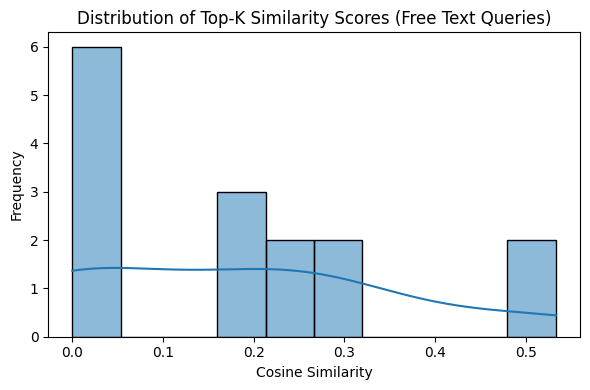

In [7]:
# 7. Score Distribution Visualization (Free Text Queries)
import matplotlib.pyplot as plt
import seaborn as sns

if not results_df.empty:
    plt.figure(figsize=(6,4))
    sns.histplot(results_df['score'], bins=10, kde=True)
    plt.title('Distribution of Top-K Similarity Scores (Free Text Queries)')
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Frequency')
    plt.tight_layout()
else:
    print('No results to visualize.')

## Summary

This notebook:
- Loaded config and job data
- Built a TF-IDF job index
- Saved & reloaded artifacts to confirm integrity
- Executed free-text and resume-based queries
- Visualized score distribution

Next possible enhancements (outside scope of this notebook):
- Add sentence-transformer embeddings and compare recall@K
- Implement filtering (location, company) pre or post retrieval
- Introduce re-ranking model using engineered features
- Add evaluation set with relevance judgments for metrics (MRR, nDCG)